In [223]:
import numpy as np
import matplotlib.pyplot as plt
from utils import run_episode, get_prior
from env import AssortmentEnvironment
from base_agents import RandomAgent
from bintrees import FastRBTree
from scipy.special import xlogy
import ipdb

In [224]:
N = 10
K = 3
T = 1000

In [225]:
agent = RandomAgent(
    k=K,
    n=N,
)

# Actual experiments with printing
experiment_data = []
run_preferences = get_prior(
    n_items=N,
    prior_type="uniform",
    fallback_weight=None,
)
env = AssortmentEnvironment(n=N, v=run_preferences)

obs_run, rewards_run = run_episode(
    envnmt=env, actor=agent, n_steps=T, verbose=False
)

100%|██████████| 1000/1000 [00:00<00:00, 9686.12it/s]


In [226]:
obs_run[:10]

[(array([3, 4, 9]), 10),
 (array([6, 4, 8]), 10),
 (array([6, 4, 2]), 2),
 (array([2, 1, 4]), 1),
 (array([0, 3, 8]), 10),
 (array([4, 7, 3]), 7),
 (array([7, 4, 3]), 10),
 (array([8, 9, 5]), 10),
 (array([4, 5, 8]), 10),
 (array([9, 3, 1]), 1)]

In [227]:
def action_statistics(observations, n_items):
    action_to_id = {}
    count = 0
    probas = []
    zero_given_x = []
    for action, observation in observations:
        action = tuple(sorted(list(action)))
        if action in action_to_id:
            ix = action_to_id[action]
            probas[ix] += 1.
            if observation == n_items:
                zero_given_x[ix] += 1.
        else:
            action_to_id[action] = count
            probas.append(1.)
            zero_given_x.append(1. if observation == n_items else 0)
            count += 1
    probas = np.array(probas)
    zero_given_x = np.array(zero_given_x)
    zero_given_x = zero_given_x / probas
    probas /= len(observations)
    assert probas.shape[0] == count
    assert zero_given_x.shape[0] == count
    assert probas.sum() < (1 + 1e-5)
    assert probas.sum() > (1 - 1e-5)
    id_to_action = {ix: action for (action, ix) in action_to_id.items()}
    return id_to_action, probas, zero_given_x 

In [285]:
id_to_action, x_probas, zero_given_x = action_statistics(observations=obs_run, n_items=N)

In [286]:
p_0 = len([x for (x, it) in obs_run if it == N]) / len(obs_run)
p_0

0.53

In [287]:
sorting_indexes = np.argsort(zero_given_x)
id_to_actions = [id_to_action[ix] for ix in sorting_indexes]
zero_given_x = zero_given_x[sorting_indexes]
x_probas = x_probas[sorting_indexes]

In [288]:
(x_probas * zero_given_x).sum()

0.53

In [289]:
n_actions = zero_given_x.shape[0]
n_actions

120

In [318]:
m_actions

25

In [319]:
n_per_set = 2 * (n_actions // m_actions)
S = FastRBTree()
S.insert(0, 0)
S.insert(n_actions, n_actions)
p_inf = np.zeros(n_actions + 1)
p_inf_c = np.zeros(n_actions + 1)
for ix in range(1, n_actions + 1):
    p_inf[ix] = p_inf[ix - 1] + x_probas[ix - 1]
    p_inf_c[ix] = (p_inf[ix - 1] * p_inf_c[ix - 1] + zero_given_x[ix - 1] * x_probas[ix - 1])/ p_inf[ix]

In [320]:
x_probas

array([0.008, 0.003, 0.004, 0.012, 0.005, 0.013, 0.004, 0.008, 0.012,
       0.004, 0.008, 0.007, 0.007, 0.01 , 0.01 , 0.009, 0.006, 0.009,
       0.006, 0.009, 0.006, 0.006, 0.006, 0.003, 0.006, 0.006, 0.008,
       0.008, 0.008, 0.005, 0.005, 0.015, 0.01 , 0.01 , 0.014, 0.007,
       0.007, 0.007, 0.014, 0.009, 0.009, 0.009, 0.009, 0.009, 0.011,
       0.011, 0.011, 0.011, 0.006, 0.006, 0.01 , 0.004, 0.006, 0.006,
       0.006, 0.012, 0.008, 0.004, 0.008, 0.008, 0.008, 0.01 , 0.004,
       0.013, 0.011, 0.009, 0.009, 0.009, 0.009, 0.009, 0.009, 0.014,
       0.007, 0.007, 0.012, 0.015, 0.005, 0.005, 0.005, 0.01 , 0.005,
       0.008, 0.008, 0.008, 0.008, 0.008, 0.011, 0.011, 0.011, 0.011,
       0.011, 0.012, 0.012, 0.006, 0.006, 0.009, 0.01 , 0.01 , 0.01 ,
       0.007, 0.007, 0.008, 0.008, 0.008, 0.008, 0.009, 0.009, 0.009,
       0.005, 0.005, 0.005, 0.01 , 0.011, 0.012, 0.007, 0.015, 0.008,
       0.003, 0.004, 0.009])

In [321]:
p_inf_c

array([0.        , 0.        , 0.        , 0.        , 0.07407407,
       0.09375   , 0.13333333, 0.14285714, 0.15789474, 0.17391304,
       0.17808219, 0.18518519, 0.19318182, 0.2       , 0.20952381,
       0.2173913 , 0.22580645, 0.23076923, 0.23741007, 0.24137931,
       0.24675325, 0.25      , 0.25301205, 0.25581395, 0.25714286,
       0.25966851, 0.26203209, 0.26666667, 0.27093596, 0.27488152,
       0.27777778, 0.28054299, 0.28813559, 0.29268293, 0.296875  ,
       0.3037037 , 0.30685921, 0.30985915, 0.31271478, 0.31803279,
       0.32165605, 0.3250774 , 0.32831325, 0.3313783 , 0.33428571,
       0.33795014, 0.34139785, 0.34464752, 0.34771574, 0.35      ,
       0.35221675, 0.35576923, 0.35714286, 0.35915493, 0.36111111,
       0.3630137 , 0.36666667, 0.36899563, 0.37012987, 0.37234043,
       0.37447699, 0.37654321, 0.37903226, 0.38      , 0.38401559,
       0.38740458, 0.3902439 , 0.39298893, 0.39564428, 0.39821429,
       0.40070299, 0.40311419, 0.40709459, 0.40901503, 0.41089

In [322]:
np.clip(-0.01, 0., 1.)

0.0

In [323]:
def f_function(t, p0):
    t = np.clip(t, 0., 1.)
    return xlogy(t, t/p0) + xlogy(1-t, (1-t) / (1 - p0))

In [324]:
def query_improvement(idx, data, p_i, p_i_c, p0):
    s_left = data.prev_item(idx)[0]
    s_right = data.succ_item(idx)[0]
    p = p_i[idx] - p_i[s_left]
    q = p_i[s_right] - p_i[idx]
    alpha = (p_i[idx] * p_i_c[idx] - p_i[s_left] * p_i_c[s_left]) / p
    beta = (p_i[s_right] * p_i_c[s_right] - p_i[idx] * p_i_c[idx]) / q
    improv = f_function(t=alpha, p0=p0) * p + f_function(t=beta, p0=p0) * q - (p + q) * f_function(t=(alpha * p + beta * q)/(p+q), p0=p0)
    if np.isnan(improv):
        ipdb.set_trace()
    return f_function(t=alpha, p0=p0) * p + f_function(t=beta, p0=p0) * q - (p + q) * f_function(t=(alpha * p + beta * q)/(p+q), p0=p0)

In [325]:
np.arange(1, 6)

array([1, 2, 3, 4, 5])

In [326]:
indexes_available = np.ones(n_actions+1, dtype=bool)
indexes_available[n_actions] = False
indexes_available[0] = False
indexes = np.arange(n_actions+1, dtype=int)
for step_idx in range(m_actions - 1):
    largest_imp = -1
    index_added = None
    random_indexes = np.random.choice(indexes[indexes_available], size=n_per_set, replace=False)
    for index_candidate in random_indexes:
        S.insert(index_candidate, index_candidate)
        improvement = query_improvement(idx=index_candidate, data=S, p_i=p_inf, p_i_c=p_inf_c, p0=p_0)
        if improvement > largest_imp:
            largest_imp = improvement
            index_added = index_candidate
        S.remove(index_candidate)
    print(f"improvement {largest_imp}, with {index_added} at step {step_idx + 1}")
    indexes_available[index_added] = False
    S.insert(index_added, index_added)

improvement 0.04398059259912654, with 52 at step 1
improvement 0.014085440417260293, with 101 at step 2
improvement 0.007071673396858328, with 13 at step 3
improvement 0.002650355478176078, with 79 at step 4
improvement 0.0018829663556913581, with 5 at step 5
improvement 0.0016342775903797659, with 112 at step 6
improvement 0.0011940427355468727, with 119 at step 7
improvement 0.0016943523721833949, with 29 at step 8
improvement 0.0003594018942492988, with 61 at step 9
improvement 0.00032507494010598336, with 94 at step 10
improvement 0.002034145585641446, with 3 at step 11
improvement 0.0002079678127531819, with 44 at step 12
improvement 0.00013230902882642036, with 70 at step 13
improvement 0.00029114256592053557, with 115 at step 14
improvement 6.556772936300043e-05, with 90 at step 15
improvement 6.147129234411117e-05, with 22 at step 16
improvement 0.00018842179141065514, with 116 at step 17
improvement 5.514310218917911e-05, with 38 at step 18
improvement 7.09428308454229e-05, wi

In [328]:
S

RBTree({0: 0, 3: 3, 5: 5, 13: 13, 22: 22, 25: 25, 29: 29, 38: 38, 44: 44, 48: 48, 52: 52, 61: 61, 64: 64, 70: 70, 79: 79, 81: 81, 90: 90, 94: 94, 101: 101, 108: 108, 112: 112, 113: 113, 115: 115, 116: 116, 119: 119, 120: 120})

In [332]:
env.preferences

array([0.34094169, 0.57824906, 0.16671755, 0.14199779, 0.18901788,
       0.34194418, 0.25415071, 0.84073806, 0.20656861, 0.00955516,
       1.        ])

In [336]:
print([key for key in sorted(S.keys())[1:]])

[3, 5, 13, 22, 25, 29, 38, 44, 48, 52, 61, 64, 70, 79, 81, 90, 94, 101, 108, 112, 113, 115, 116, 119, 120]


In [337]:
print([id_to_actions[key-1] for key in sorted(S.keys())[1:]])

[(0, 6, 9), (4, 5, 7), (0, 1, 9), (1, 4, 7), (0, 3, 7), (3, 7, 8), (4, 6, 8), (1, 7, 9), (2, 4, 6), (1, 3, 8), (2, 5, 7), (1, 2, 6), (0, 3, 5), (0, 2, 6), (0, 5, 6), (7, 8, 9), (5, 8, 9), (2, 3, 9), (5, 6, 8), (0, 4, 9), (4, 5, 9), (2, 4, 8), (2, 8, 9), (0, 4, 7), (4, 8, 9)]


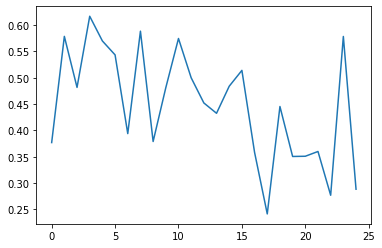

In [340]:
y_vals = np.array([env.preferences[list(id_to_actions[key-1])].sum() for key in sorted(S.keys())[1:]])
y_vals = y_vals / (1. + y_vals)
x_vals = np.arange(len(y_vals))
plt.plot(x_vals, y_vals)